In [1]:
%matplotlib ipympl
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from ssc import ssc

In [2]:
frame_files = sorted(glob.glob("frames/frame_*.png"))

In [3]:
frames = [cv2.imread(frame_file, cv2.IMREAD_COLOR) for frame_file in frame_files[:300]]    

In [11]:
plt.imshow(frames[0][:, :, ::-1])

In [12]:
w = 1920
h = 1080
fx = 1184.51770
fy = 1183.63810
cx = 978.30778
cy = 533.85598
camera_matrix = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

orb = cv2.ORB_create()
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
fast = cv2.FastFeatureDetector_create(threshold=12)
num_ret_points = 3000
tolerance = 0.1
num_matches = int(0.8*num_ret_points)  # keep only best 80 % of the matches

In [13]:
def extract_kp_des(frame, fast, orb):
    kp = fast.detect(frame, None)
    kp = sorted(kp, key = lambda x:x.response, reverse=True)
    kp = ssc(kp, num_ret_points, tolerance, frame.shape[1], frame.shape[0])
    kp, des = orb.compute(frame, kp)
    # good features to track lead to cleaner tracks, but much more noisy pose estimates
    #kp = cv2.goodFeaturesToTrack(frame, **feature_params)
    #kp = cv2.KeyPoint_convert(kp)
    #kp, des = orb.compute(frame, kp)
    return kp, des


def match(bf, last_keyframe, current_frame, last_des, des, last_kp, kp, distance_threshold=25.0, draw=True):
    matches = bf.match(last_des, des)
    matches = sorted(matches, key = lambda x:x.distance)
    # filter out matches with distance (descriptor appearance) greater than threshold
    matches = [m for m in matches if m.distance < distance_threshold]
    print("Found {} matches of current frame with last frame".format(len(matches)))
    last_pts = np.array([last_kp[m.queryIdx].pt for m in matches]).reshape(1, -1, 2)
    current_pts = np.array([kp[m.trainIdx].pt for m in matches]).reshape(1, -1, 2)
    match_frame = np.zeros_like(current_frame)
    if draw:
        match_frame = cv2.drawMatches(last_keyframe, last_kp, current_frame, kp, matches[:250], None)
    return matches, last_pts, current_pts, match_frame


def to_twist(R, t):
    """Convert a 3x3 rotation matrix and translation vector (shape (3,))
    into a 6D twist coordinate (shape (6,))."""
    r, _ = cv2.Rodrigues(R)
    twist = np.zeros((6,))
    twist[:3] = r.reshape(3,)
    twist[3:] = t.reshape(3,)
    return twist


def from_twist(twist):
    """Convert a 6D twist coordinate (shape (6,)) into a 3x3 rotation matrix
    and translation vector (shape (3,))."""
    r = twist[:3].reshape(3, 1)
    t = twist[3:].reshape(3, 1)
    R, _ = cv2.Rodrigues(r)
    return R, t


def get_frame(cap, mapx, mapy):
    """Reads and undistorts next frame from stream."""
    retc, frame = cap.read()
    if not retc:
        raise RuntimeError("Could not read the first camera frame.")
    frame = cv2.remap(frame, mapx, mapy, cv2.INTER_CUBIC)  # undistort frame
    return frame


def gray(frame):
    """Convert BGR frame to gray frame."""
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    return frame_gray

In [14]:
# TODO: initialization is not very robust and only works for some special cases, need to change to homography initialization

In [15]:
def initialize(fast, orb, camera_matrix, min_parallax=60.0):
    """Initialize two keyframes, the camera poses and a 3D point cloud.

    Args:
        min_parallax (`float`): Threshold for the median distance of all
            keypoint matches between the first keyframe (firs frame) and the
            second key frame. Is used to determine which frame is the second
            keyframe. This is needed to ensure enough parallax to recover
            the camera poses and 3D points.
    """
    pose_graph = nx.Graph()  # stores keyframe poses and data (keypoints, ORB descriptors, etc.)
    map_points = np.empty(shape=(0, 3), dtype=np.float64)

    # get first key frame
    frame = frames[0]
    kp, des = extract_kp_des(gray(frame), fast, orb)
    pose_graph.add_node(0, frame=frame, kp=kp, des=des)

    frame_idx_init = 0

    for frame in frames[1:]:
        
        frame_idx_init += 1

        # extract keypoints and match with first key frame
        kp, des = extract_kp_des(gray(frame), fast, orb)
        matches, last_pts, current_pts, match_frame = match(bf,
            gray(pose_graph.nodes[0]["frame"]), gray(frame), pose_graph.nodes[0]["des"],
            des, pose_graph.nodes[0]["kp"], kp, num_matches, draw=False)

        # determine median distance between all matched feature points
        median_dist = np.median(np.linalg.norm(last_pts.reshape(-1, 2)-current_pts.reshape(-1, 2), axis=1))
        print(median_dist)

        # if distance exceeds threshold choose frame as second keyframe
        if median_dist >= min_parallax:# and frame_idx_init >= 20:
            pose_graph.add_node(1, frame=frame, kp=kp, des=des)
            break

    pose_graph.add_edge(0, 1, matches=matches)

    # separately store the keypoints in matched order for tracking later
    pose_graph.nodes[0]["kp_idx"] = np.array([m.queryIdx for m in matches])
    pose_graph.nodes[1]["kp_idx"] = np.array([m.trainIdx for m in matches])

    # compute relative camera pose for second frame
    essential_mat, _ = cv2.findEssentialMat(last_pts.reshape(1, -1, 2), current_pts.reshape(1, -1, 2), camera_matrix, method=cv2.LMEDS)  # RANSAC fails here
    num_inliers, R, t, mask = cv2.recoverPose(essential_mat, last_pts.reshape(1, -1, 2), current_pts.reshape(1, -1, 2), camera_matrix)
    mask = mask.astype(np.bool).reshape(-1,)
    print(num_inliers)

    if num_inliers >= 0.25*current_pts.reshape(1, -1, 2).shape[1]:
        print("init R", R)
        print("init t", t)

        # relative camera pose
        R1 = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]).astype(np.float64)
        t1 = np.array([[0], [0], [0]]).astype(np.float64)
        R2 = R.T
        t2 = -np.matmul(R.T, t.reshape(3,)).reshape(3,1)

        # insert pose (in twist coordinates) of KF0 and KF1 into keyframes dict
        # poses are w.r.t. KF0 which is the base coordinate system of the entire map
        pose_graph.nodes[0]["pose"] = to_twist(R1, t1)
        pose_graph.nodes[1]["pose"] = to_twist(R2, t2)

        # create projection matrices needed for triangulation of initial 3D point cloud
        proj_matrix1 = np.hstack([R1.T, -R1.T.dot(t1)])
        proj_matrix2 = np.hstack([R2.T, -R2.T.dot(t2)])
        proj_matrix1 = camera_matrix.dot(proj_matrix1)
        proj_matrix2 = camera_matrix.dot(proj_matrix2)

        # triangulate initial 3D point cloud
        pts_3d = cv2.triangulatePoints(proj_matrix1, proj_matrix2, last_pts.reshape(-1, 2).T, current_pts.reshape(-1, 2).T).T
        pts_3d = cv2.convertPointsFromHomogeneous(pts_3d).reshape(-1, 3)

        # filter outliers based on mask from recoverPose
        #pts_3d = pts_3d[valid_map_points_mask, :].reshape(-1, 3)

        # add triangulated points to map points
        map_points = np.vstack((map_points, pts_3d))  # map_points stores 3D points w.r.t. KF0
        
        #map_points_info.append({  # stores keypoints and ORB descriptors associated to each map point
        #    0: ([pose_graph.nodes[0]["kp"][m.queryIdx] for m in pose_graph.edges[(0, 1)]["matches"]],
        #        [pose_graph.nodes[0]["des"][m.queryIdx] for m in pose_graph.edges[(0, 1)]["matches"]]), 
        #    1: ([pose_graph.nodes[1]["kp"][m.trainIdx] for m in pose_graph.edges[(0, 1)]["matches"]],
        #        [pose_graph.nodes[1]["des"][m.trainIdx] for m in pose_graph.edges[(0, 1)]["matches"]])})

        # store indices of map points belonging to KF0 and KF1 in pose graph node
        pose_graph.nodes[0]["associated_map_points"] = np.arange(0, pts_3d.shape[0])
        pose_graph.nodes[1]["associated_map_points"] = np.arange(0, pts_3d.shape[0])

        print("Initialization successful. Chose frames 0 and {} as key frames".format(frame_idx_init))

    else:
        raise RuntimeError("Could not recover intial camera pose based on selected keyframes. Insufficient parallax or number of feature points.")

    # TODO: perform full BA to optimize initial camera poses and map points [see. ORB_SLAM IV. 5)]

    return pose_graph, map_points, frame_idx_init

In [16]:
pose_graph, map_points, frame_idx = initialize(fast, orb, camera_matrix, min_parallax=60.0)

Found 1324 matches of current frame with last frame
3.0
Found 1422 matches of current frame with last frame
7.0
Found 1311 matches of current frame with last frame
10.04987562112089
Found 1411 matches of current frame with last frame
13.038404810405298
Found 1302 matches of current frame with last frame
17.0
Found 1333 matches of current frame with last frame
20.024984394500787
Found 1286 matches of current frame with last frame
23.08679276123039
Found 1337 matches of current frame with last frame
26.076809620810597
Found 1261 matches of current frame with last frame
30.066592756745816
Found 1299 matches of current frame with last frame
33.06055050963308
Found 1304 matches of current frame with last frame
36.124783736376884
Found 1292 matches of current frame with last frame
40.049968789001575
Found 1288 matches of current frame with last frame
43.104524124504614
Found 1282 matches of current frame with last frame
47.042533945356304
Found 1287 matches of current frame with last frame
5

In [17]:
pose_graph.nodes[0]["associated_map_points"]

array([   0,    1,    2, ..., 1230, 1231, 1232])

In [18]:
# get map points associated to a KF in the same order as the feature points
map_points[pose_graph.nodes[0]["associated_map_points"], :]

array([[13.31761475,  1.45177197, 19.94844452],
       [ 5.00779483,  7.47543074, 20.33402537],
       [-8.40211766, -0.74192502, 20.49784261],
       ...,
       [-0.44074669,  1.12982152, -5.63570685],
       [-0.30234757,  0.61048963, -1.0331949 ],
       [ 0.05750397,  0.55473557,  0.28256981]])

In [19]:
# get KF features & descriptors associated to map points in a KF
features_0 = [pose_graph.nodes[0]["kp"][idx] for idx in pose_graph.nodes[0]["kp_idx"]]
features_1 = [pose_graph.nodes[1]["kp"][idx] for idx in pose_graph.nodes[1]["kp_idx"]]
descriptors_0 = [pose_graph.nodes[0]["des"][idx] for idx in pose_graph.nodes[0]["kp_idx"]]
descriptors_1 = [pose_graph.nodes[1]["des"][idx] for idx in pose_graph.nodes[1]["kp_idx"]]

In [20]:
def estimate_camera_pose(img_points, pts_3d, camera_matrix):
    """Estimates the camera world pose of a frame based on 2D-3D
    corresponding points.

    Args:
        img_points (`numpy.ndarray`): A set of keypoints extracted from the
            current frame. Shape (-1, 1, 2). These keypoints can also be tracked
            from the previous frame.

        pts_3d (`numpy.ndarray`): Triangulated 3D points corresponding to
            the keypoints in img_points. Shape (-1, 1, 3). Note, that the order
            of the points in this array needs to be consistent with the order of
            keypoints in img_points.

        camera_matrix (`numpy.ndarray`): Camera matrix of the camera which
            was used to acquire frames.

    Returns:
        R (`numpy.ndarray`): Rotation matrix of the camera coordinate system
            w.r.t. world coordinate system. Shape (3, 3).
        t (`numpy.ndarray`): Translation (x, y, z) of the camera coordinate
            system w.r.t. world coordinate system. Shape (3,).

    Note:
        This function assumes keypoints to be extracted from an undistorted
        frame.
    """
    success, rvec, tvec, inliers = cv2.solvePnPRansac(pts_3d.reshape(-1, 1, 3), img_points.reshape(-1, 1, 2), camera_matrix, None, reprojectionError=8, iterationsCount=100)
    if not success:
        raise RuntimeError("Could not compute the camera pose for the new frame with solvePnP.")
    print("solvePnP success", success)
    print("solvePnP inliers", inliers.shape)
    R = cv2.Rodrigues(rvec)[0].T
    t = -np.matmul(cv2.Rodrigues(rvec)[0].T, tvec)
    return R, t

In [47]:
prev_node_id = sorted(pose_graph.nodes)[-1]
last_kf = pose_graph.nodes[prev_node_id]["frame"]
current_frame = frames[19]

In [48]:
# match current frame with last key frame
current_kp, current_des = extract_kp_des(gray(current_frame), fast, orb)
matches, last_pts, current_pts, match_frame = match(bf,
        gray(last_kf),
        gray(current_frame),
        pose_graph.nodes[prev_node_id]["des"],
        current_des, pose_graph.nodes[prev_node_id]["kp"],
        current_kp, 25.0, draw=True)

Found 1206 matches of current frame with last frame


In [49]:
# find feature points in last KF associated with the new matches
prev_node_id = sorted(pose_graph.nodes)[-1]
last_kps = [pose_graph.nodes[prev_node_id]["kp"][m.queryIdx] for m in matches]

In [46]:
len(last_kps)

1206

In [43]:
img_points = cv2.KeyPoint_convert(last_kps)
print(img_points.shape)
last_map_points = map_points[pose_graph.nodes[prev_node_id]["associated_map_points"], :]  # may contain multiple disconnected index ranges
pts_3d = last_map_points

print(pts_3d)
print(pts_3d.shape)
print(pts_3d.dtype)
#print("current_pts before PnP", img_points, "len", img_points.shape)
R_current, t_current = estimate_camera_pose(img_points, pts_3d, camera_matrix)
current_pose = to_twist(R_current, t_current)
print(R_current, t_current)

(1206, 2)
[[13.31761475  1.45177197 19.94844452]
 [ 5.00779483  7.47543074 20.33402537]
 [-8.40211766 -0.74192502 20.49784261]
 ...
 [-0.44074669  1.12982152 -5.63570685]
 [-0.30234757  0.61048963 -1.0331949 ]
 [ 0.05750397  0.55473557  0.28256981]]
(1233, 3)
float64


error: OpenCV(4.2.0) /io/opencv/modules/calib3d/src/solvepnp.cpp:216: error: (-215:Assertion failed) npoints >= 4 && npoints == std::max(ipoints.checkVector(2, CV_32F), ipoints.checkVector(2, CV_64F)) in function 'solvePnPRansac'


In [24]:
print(matches[0].queryIdx)  # index of feature point in the last_kf for match[0]
print(matches[0].trainIdx)  # index of feature point in the current_frame for match[0]

437
479


In [270]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(111)
ax.imshow(match_frame[:, :, ::-1])
cv2.imwrite("match_frame.jpg", match_frame)
plt.show()

FigureCanvasNbAgg()

In [ ]:
# project map points into image
rvec = 
tvec = 
imagePoints, jacobian = cv.projectPoints(objectPoints, rvec, tvec, camera_matrix)

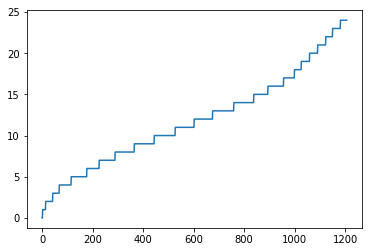

In [184]:
plt.plot([m.distance for m in matches])

In [ ]:
# TODO: keep only matches with distance smaller than threshold

In [102]:
for current_frame in frames[frame_idx+1:]:
    # get initial pose estimate by matching keypoints with previous KF
    current_kp, current_des = extract_kp_des(gray(current_frame), fast, orb)
    prev_node_id = sorted(pose_graph.nodes)[-1]
    matches, last_pts, current_pts, match_frame = match(bf,
        gray(pose_graph.nodes[prev_node_id]["frame"]),
        gray(current_frame),
        pose_graph.nodes[prev_node_id]["des"],
        current_des, pose_graph.nodes[prev_node_id]["kp"],
        current_kp, num_matches, draw=False)

    vis_current_frame = cv2.drawKeypoints(np.copy(current_frame), current_kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # recover initial camera pose of current frame by solving PnP
    img_points = current_pts
    print(img_points.shape)
    visible_map_points = pose_graph.nodes[prev_node_id]["visible_map_points"]  # may contain multiple disconnected index ranges
    try:
        pts_3d = np.vstack([map_points[vs, :] for vs in visible_map_points])
    except ValueError:
        raise ValueError ("Last keyframe did not contain any visible map points.")

    print("pts3d")
    print(pts_3d)
    print(pts_3d.shape)
    print(pts_3d.dtype)
    #print("current_pts before PnP", img_points, "len", img_points.shape)
    R_current, t_current = estimate_camera_pose(img_points, pts_3d, camera_matrix)
    current_pose = to_twist(R_current, t_current)
    print(R_current, t_current)


Found 1522 matches of current frame with last frame
(1, 1522, 2)
pts3d
[[13.31761475  1.45177197 19.94844452]
 [ 5.00779483  7.47543074 20.33402537]
 [-8.40211766 -0.74192502 20.49784261]
 ...
 [-0.44074669  1.12982152 -5.63570685]
 [-0.30234757  0.61048963 -1.0331949 ]
 [ 0.05750397  0.55473557  0.28256981]]
(1233, 3)
float64


error: OpenCV(4.2.0) /io/opencv/modules/calib3d/src/solvepnp.cpp:216: error: (-215:Assertion failed) npoints >= 4 && npoints == std::max(ipoints.checkVector(2, CV_32F), ipoints.checkVector(2, CV_64F)) in function 'solvePnPRansac'
